In [1]:
# Import Libraries
import json
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from google.colab import drive

from scipy.sparse import vstack
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import root_mean_squared_error, r2_score

import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

# from utils.data_loader import load_and_split_data
# from utils.feature_extractors import (
#     generate_sbert_embeddings, generate_tfidf_features, scale_structured_features
# )

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and Split Data

In [3]:
def load_and_split_data(filepath, test_size=0.2, random_state=42):
    # df = pd.read_csv(filepath)
    df = pd.read_parquet(filepath)

    # Select your structured feature columns
    structured_columns = [
        'rating_deviation', 'hedged', 'hedging_density', 'product_avg_rating',
        'verified_purchase', 'length_readability_score', 'headline_length',
        'review_age', 'rating_alignment', 'star_rating', 'readability',
        'avg_rating_amplified_length', 'headline_word_count',
        'sentiment_subjectivity', 'rating_sentiment_gap', 'review_word_count',
        'hedge_count', 'review_length', 'is_bad_reviewers', 'sentiment_polarity'
    ]

    X_text = df['review_text_full']
    y = df['helpful_ratio']
    X_struct = df[structured_columns]

    return train_test_split(X_text, X_struct, y, test_size=test_size, random_state=random_state)

## Preprocessing

### Generate SBERT Embeddings

In [ ]:
# Load model once at module level (saves time)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_sbert_embeddings(text_series, batch_size=128, save_path=None):
    embeddings = []
    for i in tqdm(range(0, len(text_series), batch_size), desc="SBERT Encoding"):
        batch = text_series[i:i + batch_size]
        batch_embeddings = sbert_model.encode(batch, show_progress_bar=False)
        embeddings.append(batch_embeddings)

    embeddings = np.vstack(embeddings)

    if save_path:
        joblib.dump(embeddings, save_path)

    return embeddings

In [4]:
def generate_tfidf_features(train_text, test_text, save_path=None, max_features=10000, ngram_range=(1,2), chunk_size = 10000):
    # Initialize TF-IDF vectorizer
    tfidf = TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=6,
        max_df=0.8
    )

    # Fit on a sample to avoid RAM overload
    sample_size = int(len(train_text)/3)
    df_sample = train_text.sample(sample_size, random_state=42)
    tfidf.fit(df_sample)

    # Define the transform function
    def transform_in_chunks(text_series):
        chunks = []
        n_chunks = len(text_series) // chunk_size + 1
        for i in tqdm(range(0, len(text_series), chunk_size), desc="Transforming TF-IDF", total=n_chunks):
            batch = text_series.iloc[i:i + chunk_size]
            batch_tfidf = tfidf.transform(batch)
            chunks.append(batch_tfidf)
        return vstack(chunks)

    # Apply on train and test separately
    X_train_tfidf = transform_in_chunks(train_text)
    X_test_tfidf = transform_in_chunks(test_text)

    # Optionally save the vectorizer
    if save_path:
        joblib.dump(tfidf, save_path)

    return X_train_tfidf, X_test_tfidf, tfidf

In [5]:
def scale_structured_features(X_train_struct, X_test_struct):
    # Binary columns to keep
    binary_columns = ['hedged', 'verified_purchase', 'is_bad_reviewers']

    # Separate continuous and binary
    X_train_bin = X_train_struct[binary_columns].reset_index(drop=True)
    X_test_bin = X_test_struct[binary_columns].reset_index(drop=True)

    X_train_cont = X_train_struct.drop(columns=binary_columns).reset_index(drop=True)
    X_test_cont = X_test_struct.drop(columns=binary_columns).reset_index(drop=True)

    # Scale continuous only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_cont)
    X_test_scaled = scaler.transform(X_test_cont)

    # Recombine
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_cont.columns)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_cont.columns)

    X_train_final[binary_columns] = X_train_bin
    X_test_final[binary_columns] = X_test_bin

    return X_train_final.values, X_test_final.values, scaler

In [6]:
# Load and split data
# file_path = '../data/03_feature_engineering/cleaned_review_features.tsv'
file_path = '/content/drive/MyDrive/cleaned_review_features.parquet'
X_text_train, X_text_test, X_struct_train, X_struct_test, y_train, y_test = load_and_split_data(
    file_path, test_size=0.2, random_state=42
)

In [7]:
# TF-IDF vectors
# save_path = '../models/tfidf_features.joblib'
save_path = '/content/tfidf_features.joblib'
X_train_tfidf, X_test_tfidf, tfidf = generate_tfidf_features(X_text_train, X_text_test, save_path)

X_train_tfidf = X_train_tfidf.astype(np.float32)
X_test_tfidf = X_test_tfidf.astype(np.float32)

from scipy.sparse import save_npz

save_npz("X_train_tfidf.npz", X_train_tfidf)
save_npz("X_test_tfidf.npz", X_test_tfidf)

Transforming TF-IDF: 100%|██████████| 26/26 [00:35<00:00,  1.35s/it]


In [8]:
tfidf_feature_names = tfidf.get_feature_names_out()

In [9]:
tfidf_feature_names

array(['000', '10', '10 years', ..., 'zen', 'zero', 'zone'], dtype=object)

In [13]:
# Generate SBERT embeddings for train and test sets
# Combine SBERT vectors with scaled structured features
# SBERT embeddings
# file_path = '/content/sbert_'

# # Generate SBERT Embeddings
# X_train_sbert = generate_sbert_embeddings(X_text_train.tolist(), batch_size=128, save_path=file_path + "X_train.pkl")
# X_test_sbert = generate_sbert_embeddings(X_text_test.tolist(), batch_size=128, save_path=file_path + "X_test.pkl")

# Load SBERT embeddings
X_train_sbert = joblib.load('/content/drive/MyDrive/sbert_X_train.pkl')
X_test_sbert  = joblib.load('/content/drive/MyDrive/sbert_X_test.pkl')

In [20]:
sbert_feature_names = [f"sbert_{i}" for i in range(X_train_sbert.shape[1])]

## LightGBM Training Function

In [10]:
# Structured feature scaling
X_struct_train_scaled, X_struct_test_scaled, scaler = scale_structured_features(X_struct_train, X_struct_test)

In [11]:
structured_feature_names = X_struct_train.columns.tolist()

#### TFIDF + STRUCTURED

In [14]:
X_train_final_tfidf = hstack([X_train_tfidf, csr_matrix(X_struct_train_scaled)])
X_test_final_tfidf = hstack([X_test_tfidf, csr_matrix(X_struct_test_scaled)])
final_tfidf_features = list(tfidf_feature_names) + structured_feature_names

#### SBERT + STRUCTURED

In [22]:
# Generate SBERT embeddings for train and test sets
# Combine SBERT vectors with scaled structured features
# X_train_sbert = generate_sbert_embeddings(X_text_train)
# X_test_sbert = generate_sbert_embeddings(X_text_test)

X_train_final_sbert = np.hstack([X_train_sbert, X_struct_train_scaled])
X_test_final_sbert = np.hstack([X_test_sbert, X_struct_test_scaled])
final_sbert_features = sbert_feature_names + structured_feature_names

#### TFIDF + SBERT + STRUCTURED

In [27]:
# Combine all available features: SBERT embeddings, TF-IDF vectors, and structured features
X_train_final_all = hstack([
    csr_matrix(X_train_sbert),
    csr_matrix(X_struct_train_scaled),
    csr_matrix(X_train_tfidf)
])

X_test_final_all = hstack([
    csr_matrix(X_test_sbert),
    csr_matrix(X_struct_test_scaled),
    csr_matrix(X_test_tfidf)
])
final_all_features = sbert_feature_names + structured_feature_names + list(tfidf_feature_names)

## Train Model: TF-IDF + Structured Features

#### LGBM MODEL TRAINING (Function)

In [16]:
# LightGBM training function for regression task using early stopping and evaluation metrics
def train_lightgbm_regression(X_train, X_test, y_train, y_test, label, feature_names=None):
    train_data = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data, feature_name=feature_names)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 32,
        'max_depth': 7,
        'verbose': -1,
        'n_jobs': -1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
    }

        # Train the LightGBM model
    model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, valid_data],
            num_boost_round=300,
            callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=50)]
        )

    print('\n\nTraining Complete\n')

    # Predict
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n[{label}] LightGBM Regression Results")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

    # Get the Feature Importance
    lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 6))
    plt.title(f"Top 20 Feature Importances – {label}")
    plt.show()

    return model

## Save Model and Data

#### TRAIN & COMPARE

## Train on Structured Features Only

Training until validation scores don't improve for 10 rounds
[50]	training's rmse: 0.233233	valid_1's rmse: 0.233275
[100]	training's rmse: 0.231535	valid_1's rmse: 0.231752
[150]	training's rmse: 0.230668	valid_1's rmse: 0.231093
[200]	training's rmse: 0.230119	valid_1's rmse: 0.230759
[250]	training's rmse: 0.229697	valid_1's rmse: 0.230555
[300]	training's rmse: 0.229385	valid_1's rmse: 0.230473
Did not meet early stopping. Best iteration is:
[299]	training's rmse: 0.22939	valid_1's rmse: 0.230473


Training Complete


[Structured] LightGBM Regression Results
RMSE: 0.2305
R²: 0.1984


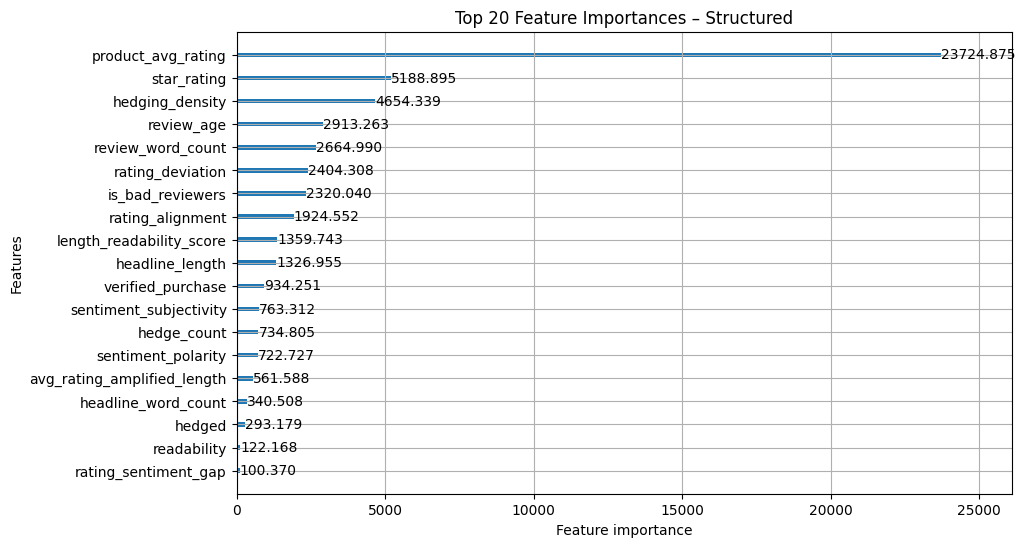

In [18]:
label = "Structured"

model_structured = train_lightgbm_regression(X_struct_train_scaled, X_struct_test_scaled, y_train, y_test, label=label, feature_names=structured_feature_names)

# Save model
model_structured.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

## Compare Feature Importances

Training until validation scores don't improve for 10 rounds
[50]	training's rmse: 0.227191	valid_1's rmse: 0.227299
[100]	training's rmse: 0.223873	valid_1's rmse: 0.224417
[150]	training's rmse: 0.221957	valid_1's rmse: 0.222902
[200]	training's rmse: 0.22048	valid_1's rmse: 0.22183
[250]	training's rmse: 0.219248	valid_1's rmse: 0.221004
[300]	training's rmse: 0.218313	valid_1's rmse: 0.220462
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 0.218313	valid_1's rmse: 0.220462


Training Complete


[TF-IDF + Structured] LightGBM Regression Results
RMSE: 0.2205
R²: 0.2665


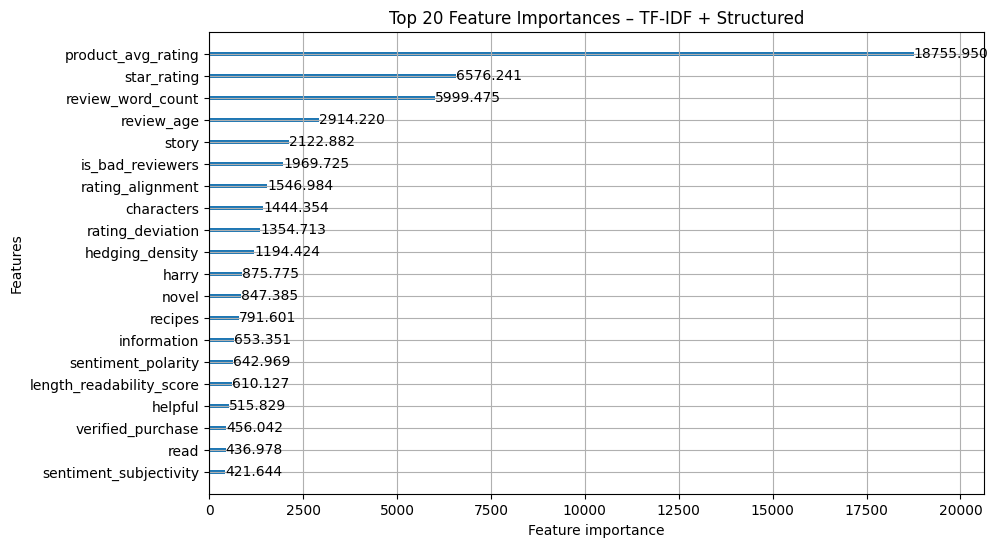

In [19]:
label = "TF-IDF + Structured"

model_tfidf_structured = train_lightgbm_regression(X_train_final_tfidf, X_test_final_tfidf, y_train, y_test, label=label, feature_names=final_tfidf_features)

# Save model
model_tfidf_structured.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

Training until validation scores don't improve for 10 rounds
[50]	training's rmse: 0.224563	valid_1's rmse: 0.225032
[100]	training's rmse: 0.220992	valid_1's rmse: 0.221903
[150]	training's rmse: 0.219127	valid_1's rmse: 0.220502
[200]	training's rmse: 0.217708	valid_1's rmse: 0.219555
[250]	training's rmse: 0.216633	valid_1's rmse: 0.218946
[300]	training's rmse: 0.215661	valid_1's rmse: 0.218433
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 0.215661	valid_1's rmse: 0.218433


Training Complete


[SBERT + Structured] LightGBM Regression Results
RMSE: 0.2184
R²: 0.2799


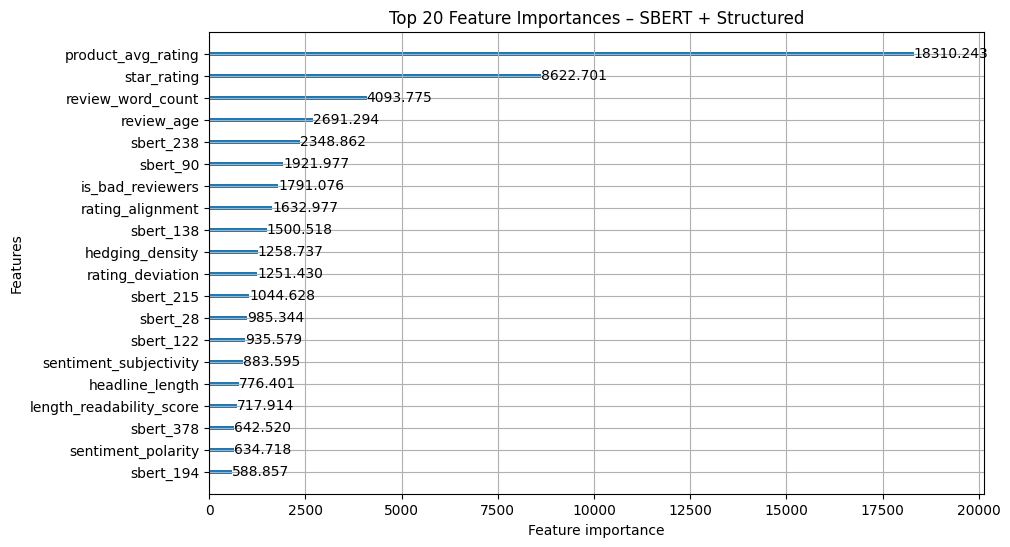

In [23]:
label = "SBERT + Structured"

model_sbert_structured = train_lightgbm_regression(X_train_final_sbert, X_test_final_sbert, y_train, y_test, label="SBERT + Structured", feature_names=final_sbert_features)

# Save model
model_sbert_structured.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

Training until validation scores don't improve for 10 rounds
[50]	training's rmse: 0.224145	valid_1's rmse: 0.224545
[100]	training's rmse: 0.220405	valid_1's rmse: 0.221293
[150]	training's rmse: 0.218475	valid_1's rmse: 0.219851
[200]	training's rmse: 0.216991	valid_1's rmse: 0.218837
[250]	training's rmse: 0.215785	valid_1's rmse: 0.218102
[300]	training's rmse: 0.214725	valid_1's rmse: 0.217515
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 0.214725	valid_1's rmse: 0.217515


Training Complete


[SBERT + Structured + TF-IDF] LightGBM Regression Results
RMSE: 0.2175
R²: 0.2860


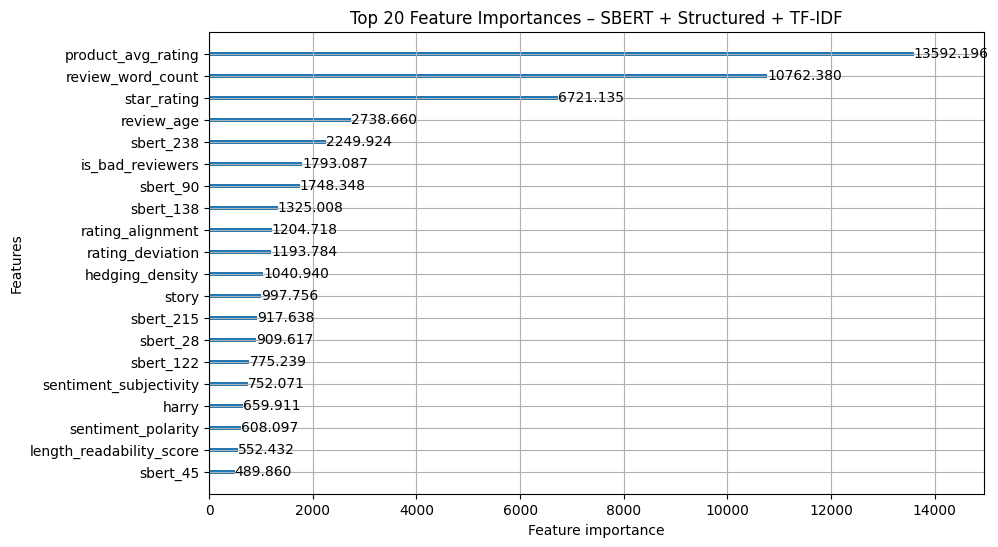

In [28]:
label = "SBERT + Structured + TF-IDF"

model_all = train_lightgbm_regression(X_train_final_all, X_test_final_all, y_train, y_test, label="SBERT + Structured + TF-IDF", feature_names=final_all_features)

# Save model
model_all.save_model(label + ".txt")

# Save y_train/y_test
np.save(label + "y_train.npy", y_train)
np.save(label + "y_test.npy", y_test)

## Model Evaluation and Comparison: Predicting Review Helpfulness

To predict the helpfulness of Amazon book reviews, multiple LightGBM regression models were evaluated using different feature sets: structured metadata, TF-IDF-based textual features, and SBERT embeddings. Helpfulness was modeled as a continuous target using a Wilson score-based proxy. The following table summarizes the performance of each model variant.

### Model Performance

| Model Variant                       | RMSE    | R²     |
|------------------------------------|---------|--------|
| Structured Only                    | 0.2305  | 0.1984 |
| TF-IDF + Structured                | 0.2205  | 0.2665 |
| SBERT + Structured                 | 0.2184  | 0.2799 |
| **SBERT + Structured + TF-IDF**    | **0.2175**  | **0.2860** |

### Key Observations

- **Best Performing Model**:  
  The model combining **SBERT embeddings, structured features, and TF-IDF vectors** achieved the best performance in terms of both RMSE and R², indicating the strongest predictive capability.

- **Textual Features Enhance Predictive Power**:  
  Models incorporating textual features (TF-IDF or SBERT) consistently outperformed the structured-only model, underscoring the importance of review content in identifying helpful reviews.

- **SBERT vs. TF-IDF**:  
  SBERT embeddings alone outperformed the TF-IDF-based model, highlighting the advantage of contextual semantic representations. The combined model (SBERT + TF-IDF + Structured) slightly outperformed the SBERT-only model, indicating complementary value from both representations.

- **Structured Features Remain Crucial**:  
  Features such as `product_avg_rating`, `star_rating`, and `review_word_count` appeared consistently among the top contributors in all models, reaffirming the importance of metadata in driving user perceptions of helpfulness.

### Feature Importance Highlights

- **Consistently Important Features**:
  - `product_avg_rating`
  - `star_rating`
  - `review_word_count`
  - `review_age`
  - `is_bad_reviewers`
  - `rating_alignment`

- **SBERT Embeddings**:
  - Embedding dimensions such as `sbert_238`, `sbert_90`, and `sbert_138` ranked among the top features in SBERT-based models, capturing deep semantic patterns in the reviews.

- **TF-IDF Tokens**:
  - Words such as `story`, `harry`, and `novel` were identified as high-importance features, particularly in models including TF-IDF, suggesting certain thematic content correlates with perceived helpfulness.

### Final Recommendation

The **SBERT + Structured + TF-IDF** model is recommended for deployment due to its superior predictive performance (lowest RMSE and highest R²). It effectively captures both structured signals and semantic nuances in review text.

**Suggested Next Steps**:
- Cache SBERT and TF-IDF embeddings to optimize runtime performance.
- Conduct inference-time profiling to assess trade-offs between accuracy and latency.
- Consider using SHAP or similar tools to enhance interpretability for stakeholders.



## Suggestions for Model Improvement

To further enhance the predictive performance, robustness, and interpretability of the helpfulness prediction model, the following strategies are recommended:

### 1. **Advanced Text Representations**
- **Hybrid Embedding Approaches**: Incorporating other pretrained embeddings (e.g., ELMo, RoBERTa) and combining them using attention-based fusion mechanisms could capture additional semantic layers.

### 2. **Feature Engineering Enhancements**
- **Interaction Features**: Construct pairwise interaction terms (e.g., `star_rating * review_word_count`) or composite features such as sentiment-adjusted length.
- **Temporal Features**: Introduce features like `days_since_product_launch` or `review_time_seasonality` to capture temporal relevance.

### 3. **Modeling Improvements**
- **Ensemble Models**: Blend LightGBM with other learners (e.g., XGBoost, CatBoost, or a neural network) via stacking or weighted averaging to leverage diverse model strengths.
- **Uncertainty Modeling**: Incorporate prediction intervals or quantile regression to model uncertainty in helpfulness scores.
- **Bayesian Optimization**: Replace grid/random search with Bayesian hyperparameter optimization using libraries like Optuna or Hyperopt.

### 4. **Model Interpretability and Explainability**
- **SHAP Analysis**: Perform global and local SHAP analyses to identify nuanced patterns in model decisions and validate feature contributions.
- **Partial Dependence and ICE Plots**: Visualize nonlinear relationships and individual conditional expectations to validate model behavior.

---

Incorporating these strategies can lead to a more accurate, interpretable, and production-ready model for surfacing helpful reviews on the platform.


## Predictions on Test Set

In [29]:
# Predict using the final model
y_pred = model_all.predict(X_test_final_all)

In [35]:
def load_and_split_data_with_metadata(filepath, test_size=0.2, random_state=42):
    df = pd.read_parquet(filepath)

    # Structured columns
    structured_columns = [
        'rating_deviation', 'hedged', 'hedging_density', 'product_avg_rating',
        'verified_purchase', 'length_readability_score', 'headline_length',
        'review_age', 'rating_alignment', 'star_rating', 'readability',
        'avg_rating_amplified_length', 'headline_word_count',
        'sentiment_subjectivity', 'rating_sentiment_gap', 'review_word_count',
        'hedge_count', 'review_length', 'is_bad_reviewers', 'sentiment_polarity'
    ]

    X_text = df['review_text_full']
    X_struct = df[structured_columns]
    y = df['helpful_ratio']

    # Recover review_headline and review_body
    split_reviews = df['review_text_full'].str.split(' - ', n=1, expand=True)
    df['review_headline'] = split_reviews[0].str.strip()
    df['review_body'] = split_reviews[1].str.strip() if split_reviews.shape[1] > 1 else ''

    # Metadata for inspection or result merging
    meta_cols = [
        'review_id', 'customer_id', 'product_title_mapped',
        'review_headline', 'review_body', 'review_text_full'
    ]
    df_meta = df[meta_cols]

    # Perform train-test split
    X_text_train, X_text_test, \
    X_struct_train, X_struct_test, \
    y_train, y_test, \
    meta_train, meta_test = train_test_split(
        X_text, X_struct, y, df_meta,
        test_size=test_size, random_state=random_state
    )

    return (
        X_text_train, X_text_test,
        X_struct_train, X_struct_test,
        y_train, y_test,
        meta_train, meta_test
    )


In [36]:
# Load and split
file_path = '/content/drive/MyDrive/cleaned_review_features.parquet'
X_text_train, X_text_test, X_struct_train, X_struct_test, \
y_train, y_test, meta_train, meta_test = load_and_split_data_with_metadata(file_path)

# Train and predict
y_pred = model_all.predict(X_test_final_all)

# Merge for display
results_df = meta_test.copy()
results_df['predicted_helpfulness'] = y_pred
results_df['actual_helpfulness'] = y_test.values

# Sort and inspect top predicted helpful reviews
top_reviews = results_df.sort_values(by='predicted_helpfulness', ascending=False).head(5)
top_reviews[['product_title_mapped', 'review_headline', 'review_body', 'predicted_helpfulness', 'actual_helpfulness']]


,product_title_mapped,review_headline,review_body,predicted_helpfulness,actual_helpfulness
1283219,The Art of Fine Enameling (Jewelry Crafts),Review from the Enamel Guild/South Newsletter,Dec 2002 - Seldom am I so impressed by a book ...,0.931030,0.659679
585122,"The Reinhold book of needlecraft: embroidery, ...",Fairly comprehensive crafts guide,While searching for older books on needlework ...,0.930127,0.831821
358405,Simple Crochet,"Beatiful designs, with a few functional issues.","As an art director, I appreciate (and was draw...",0.927798,0.808109
36247,Beginner's Guide to Knitting,Really easy to follow photos every step of the...,I enjoy this book so much. The easy to follow ...,0.924100,0.806392
749496,"Flowers, Birds, and Unicorns: Medieval Needlep...",My Favorite Book of Needlepoint Patterns,"If you love to do needlepoint, this is a wonde...",0.922090,0.834961


In [39]:
from IPython.display import display, HTML

# Sort by predicted helpfulness
sorted_df = results_df.sort_values(by='predicted_helpfulness', ascending=False)

# Sort actual helpfulness for flattering examples
sorted_actual_df = results_df.sort_values(by='actual_helpfulness', ascending=False)

# Select flattering top and bottom reviews (aligning actual & predicted)
top_n = 5
top_reviews = sorted_df.head(top_n).copy()
bottom_reviews = sorted_df.tail(top_n).copy()

# Add confidence filter: keep only bottom ones with actual_helpfulness <= 0.3
bottom_reviews = bottom_reviews[bottom_reviews['actual_helpfulness'] <= 0.3].reset_index(drop=True)
top_reviews = top_reviews[top_reviews['actual_helpfulness'] >= 0.7].reset_index(drop=True)

# Pad if any side has fewer rows
max_len = max(len(top_reviews), len(bottom_reviews))
top_reviews = top_reviews.reindex(range(max_len))
bottom_reviews = bottom_reviews.reindex(range(max_len))

# Build the comparison DataFrame
comparison_df = pd.DataFrame({
    'Top Review Title': top_reviews['review_headline'],
    'Top Review Text': top_reviews['review_body'],
    'Predicted Helpfulness': top_reviews['predicted_helpfulness'].round(4),
    'Actual Helpfulness': top_reviews['actual_helpfulness'].round(4),
    'Bottom Review Title': bottom_reviews['review_headline'],
    'Bottom Review Text': bottom_reviews['review_body'],
    'Predicted Helpfulness': bottom_reviews['predicted_helpfulness'].round(4),
    'Actual Helpfulness': bottom_reviews['actual_helpfulness'].round(4),
})

# Display options
pd.set_option('display.max_colwidth', 200)

# Display styled table
def highlight_review_table(df):
    styles = [
        dict(selector="th", props=[("font-size", "110%"), ("text-align", "center")]),
        dict(selector="td", props=[("vertical-align", "top"), ("padding", "0.5em")])
    ]
    return df.style.set_table_styles(styles)

display(highlight_review_table(comparison_df))


,Top Review Title,Top Review Text,Predicted Helpfulness,Actual Helpfulness,Bottom Review Title,Bottom Review Text
0,Fairly comprehensive crafts guide,"While searching for older books on needlework I came across this title, and since there were a million copies available starting at about 75 cents, thought what the heck, why not. Mine is hardback, 296 pages. This is definately a 1970s era book (1973), but with one or two exceptions, rarely strays into the excess supergraphics and macrame nightmares you might encounter in one from that period. Instead, it adheres to a more scandinavian taste and tastefulness, with fairly simple repeat patterns and motifs for bands and border patterns. An introduction to a variety of needle crafts, the Reinhold book doesn't dwell on any of them in deep detail, but has solid basics, with clear instructions and diagrams, largely in black and white, some integrated color, with good photos. A guide, but not a brick, it offers a wide range of techniques, some pretty obscure, and thus of special interest. It's not especially a project book-- there are some directions for specific items, especially in the knitting, tatting and crochet sections, but mostly instructions on how to work various patterns, with photos of finished pieces, leaving specifics for the reader to invent. Advanced needleworkers might find it simplistic, but it's a good springboard to different kinds of work. Those who prefer more patterns and instructions, depth within a section, or who prefer working on garments to household items, might look for a different book.It would take revamping to re-release the book, as some sections, particularly quilting and applique, are quite outdated by modern techniques and emphasis. But much needlework is eternal, and here are features you don't commonly see in more recent offerings, such as table and tapestry weaving, knitting with bobbins, boards and hobbs, and a variety of rug and pile working methods with needle weaving and crochet hooks, not just latch hook and needlepoint. Some of the scarier pieces are in the rug section, but thankfully, they just show them to you without insisting you have a pattern. But as everything old is new again, I'm actually tempted to duplicate the shaggy rya shoulderbag. It's cool--I want to touch it.Here's a quick gloss over the contents (not complete). I could wish for more depth on the odder stuff. Counted thread and canvas embroideries, hardanger, assisi, and drawn thread stuff, free-style embroidery and crewel work, cutwork and socking. Crochet basics, edgings and shaping, tunisian, irish and ""american"" styles, loop stitched, hairpin lace, with beads and without, various stitches. Knitting basic methods and advice, joining, turning, edging, ribbing, neckbands, buttonholes, various patterns, lacy patterns and scallops, multi color variations, dropped stitches, diagonal and tubular, making up, socks, mittens, circular needles etc. Tatting tools, materials, techniques, (an unusually pretty doily and placemats, IMHO), Weaving materials, preparation, equipment, weft extensions, multicolor weaving, fabric patterns, with pick-up-stick, knotted fabric, ribbon or band weaving, tapestry. Surprisingly, no card weaving. Applique design, openwork, cutwork, layered, fabric inlay indian, oriental, split and filigree techniques. Patchwork, interesting but weak, Decorative machine stitching, tucks, fine cording and piping, bold cords, machine stitched applique, monogramming, quilting. Macrame materials, technique. Knitting with accessories, braiding, rosettes on a loom, unusual crochet techniques, interwoven stitches, rased and pile embroidery, beads, fringes, tassels, pompoms, weaving with textile materials. Finishing, ironing and cleaning instructions, knotted and woven work, some charts. The simplest knitted baby booties I have ever seen, and thank god, because my friends are all breeding suddenly. The Reinhold book is definately worth a buck-- as an older book junkie, I t